# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch_geometric import seed_everything
from torch_geometric.nn import SAGEConv, to_hetero

import sys
sys.path.append("../../..")
from src.models import training_utils, base_model,sage_ones

seed = 4
seed_everything(seed)

data_folder = f"../../../data/processed/graph_data_nohubs/merged_types/split_dataset/"
feature_folder = "../../../data/processed/feature_data/"
reports_folder = "../../../reports/"
results_folder = "../../../reports/random_walks/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data

In [2]:
walk_1_results = pd.read_csv(results_folder+"walk_3/random_walk_results.csv",index_col=0)
walk_2_results = pd.read_csv(results_folder+"walk_4/random_walk_results.csv",index_col=0)

walk_2_results["walk"] = 4
walk_1_results["walk"] = 3 
total_walk = pd.concat([walk_1_results,walk_2_results]).reset_index(names="walk_index")
total_walk["T"] = total_walk.walk.apply(lambda x: 0.1 if x == 3 else 0.2)

model_params = total_walk.sort_values(by="mean_auc",ascending=False).iloc[0].to_dict()
model_params["supervision_types"] = [("gene_protein","gda","disease")]

In [3]:
seeds = [4]
data = []
for seed in seeds:
    datasets, node_map = training_utils.load_data(data_folder+f"seed_{seed}/")
    data.append(datasets)

full_set = torch.load(data_folder+f"seed_{seeds[-1]}/full_dataset.pt")
node_df = pd.read_csv(data_folder+f"seed_{seeds[-1]}/tensor_df.csv",index_col=0).set_index("node_index",drop=True)

# Trato de escribir el modelo a mano

In [70]:
class GraphBlock(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout,residual_block):
        super().__init__()

        self.residual_block = residual_block
        self.conv = SAGEConv(input_dim,output_dim,aggr="mean")
        self.bn = torch.nn.BatchNorm1d(output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.LeakyReLU()
    
    def forward(self,x,edge_index):
        identity = x
        out = self.conv(x,edge_index)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.relu(out)

        if self.residual_block:
            out += identity
            out = torch.nn.functional.leaky_relu(out)
        
        return out

    def reset_parameters(self):
        self.conv.reset_parameters()
        self.bn.reset_parameters()

    
class PostProcessMLP(torch.nn.Module):
    def __init__(self,input_dim,output_dim,dropout):
        super().__init__()

        self.post_linear_1 = torch.nn.Linear(input_dim,output_dim)
        self.post_linear_bn = torch.nn.BatchNorm1d(output_dim)
        self.post_linear_dropout = torch.nn.Dropout(dropout)
        self.post_linear_act = torch.nn.LeakyReLU()
        self.post_linear_2 = torch.nn.Linear(output_dim,output_dim)

    def forward(self,x):
        x = self.post_linear_1(x)
        x = self.post_linear_bn(x)
        x = self.post_linear_dropout(x)
        x = self.post_linear_act(x)
        x = self.post_linear_2(x)

        return x
    
    def reset_parameters(self):
        self.post_linear_1.reset_parameters()
        self.post_linear_bn.reset_parameters()
        self.post_linear_2.reset_parameters()

class Encoder(torch.nn.Module):
    def __init__(self,output_dim,dropout,metadata):
        super().__init__()

        self.graph_layer_1 = to_hetero(GraphBlock(-1,output_dim,dropout,False),metadata,aggr="mean")
        self.graph_layer_2 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.graph_layer_3 = to_hetero(GraphBlock(output_dim,output_dim,dropout,True),metadata,aggr="mean")
        self.post_mlp = to_hetero(PostProcessMLP(output_dim,output_dim,dropout),metadata)

    
    def forward(self,x:dict,edge_index:dict):
        x = self.graph_layer_1(x,edge_index)
        x = self.graph_layer_2(x,edge_index)
        x = self.graph_layer_3(x,edge_index)
        x = self.post_mlp(x)
        return x

class InnerProductDecoder(torch.nn.Module):
    def __init__(self,supervision_types):
        super().__init__()
        self.supervision_types = supervision_types

    def forward(self,x:dict,edge_label_index:dict) -> dict:
        pred_dict = {}
        for edge_type in self.supervision_types:
            edge_index = edge_label_index[edge_type]

            source_type, _ , target_type = edge_type
            
            x_source = x[source_type]
            x_target = x[target_type]

            source_index, target_index = edge_index[0], edge_index[1]

            nodes_source = x_source[source_index]
            nodes_target = x_target[target_index]

            pred = (nodes_source * nodes_target).sum(dim=1)

            pred = torch.sigmoid(pred)
            pred_dict[edge_type] = pred
        
        return pred_dict

class Model(torch.nn.Module):
    def __init__(self,metadata,supervision_types):
        super().__init__()
          
        self.encoder = Encoder(64,0.1,metadata)
        self.decoder = InnerProductDecoder(supervision_types)
        self.loss_fn = torch.nn.BCELoss()
        self.supervision_types = supervision_types
    
    
    def forward(self,x:dict,edge_index:dict,edge_label_index:dict) -> dict:
        x = self.encoder(x,edge_index)
        pred = self.decoder(x,edge_label_index)
        return pred
    
    def loss(self, prediction_dict, label_dict):
        loss = 0
        for edge_type,pred in prediction_dict.items():
            y = label_dict[edge_type]
            loss += self.loss_fn(pred, y.type(pred.dtype))
        return loss

# Run experiment aver si funciona igual

In [68]:
def run_experiment(params, train_set, val_set,negative_sampler):
    # Initialize node features
    if params["feature_type"] not in ["lsa","lsa_norm","lsa_scaled"]:
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"]
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"]
        )
    else:
        #TODO: sacar el data_folder este
        train_set = training_utils.initialize_features(
            train_set, params["feature_type"], params["feature_dim"], feature_folder
        )
        val_set = training_utils.initialize_features(
            val_set, params["feature_type"], params["feature_dim"], feature_folder
        )

    train_set.to(device)
    val_set.to(device)
    model = Model(train_set.metadata(),[("gene_protein","gda","disease")])
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"]
    )
    train_losses = []
    val_losses = []
    train_scores = []
    val_scores = []

    epochs = params["epochs"]

    early_stopper = training_utils.EarlyStopper(params["patience"], params["delta"])
    train_label_index = train_set["gene_protein","gda","disease"]["edge_label_index"]
    for epoch in range(epochs):
        #Resample negative supervision links every k epochs
        if epoch%params["sample_epochs"] == 0:
            # sample_index = torch.randint(high=train_label_index.shape[1], size=(round(params["sample_ratio"]*train_label_index.shape[1]),))
            # positive_sample = train_label_index[:,sample_index]

            # positive_sample = train_label_index
            new_train_label_index, new_train_label = negative_sampler.get_labeled_tensors(train_label_index.cpu(),"corrupt_both")
            train_set["gene_protein","gda","disease"]["edge_label_index"] = new_train_label_index.to(device)
            train_set["gene_protein","gda","disease"]["edge_label"] = new_train_label.to(device)

        train_loss = training_utils.train(model, optimizer, train_set)
        val_loss = training_utils.get_val_loss(model, val_set)

        train_score = training_utils.test(model, train_set)
        val_score = training_utils.test(model, val_set)

        train_losses.append(train_loss)
        train_scores.append(train_score)

        val_scores.append(val_score)
        val_losses.append(val_loss)

        if early_stopper.early_stop(val_loss):
            print("Early stopping")
            break

    val_auc = training_utils.test(model, val_set)
    curve_data = [train_losses, val_losses, train_scores, val_scores]

    return val_auc, model, curve_data

def run_multiple_seeds(datasets,experiment_params,negative_sampler):
    experiment_metrics = []
    models = []
    curves = []
    for seed_dataset in datasets:
        train_data, val_data = seed_dataset
        seed_auc, trained_model, training_curve = run_experiment(experiment_params,train_data,val_data,negative_sampler)
        experiment_metrics.append(seed_auc)
        models.append(trained_model)
        curves.append(training_curve)
    
    metrics = (np.mean(experiment_metrics),np.std(experiment_metrics))
    
    return [metrics, models, curves]

(0.87, 0.0)


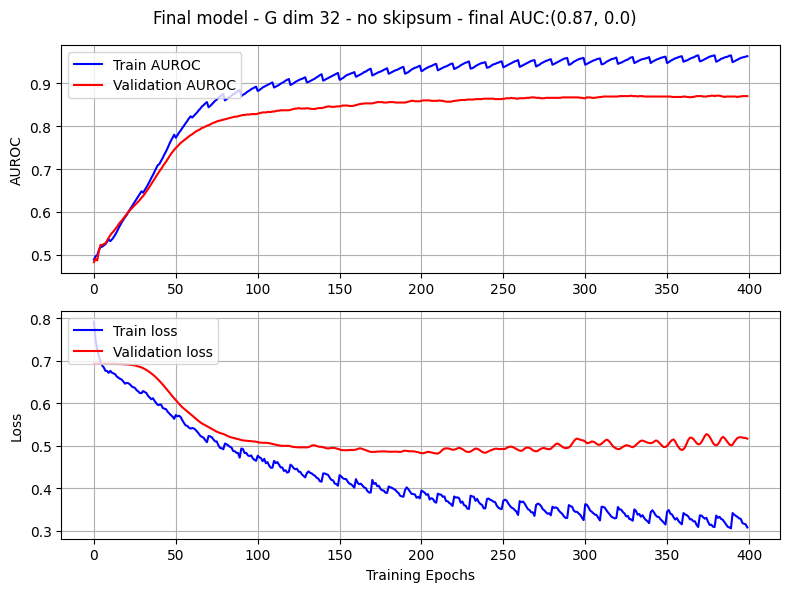

In [71]:
negative_sampler = training_utils.NegativeSampler(full_set,("gene_protein","gda","disease"),full_set["gene_protein"]["degree_gda"],full_set["disease"]["degree_gda"])
results = {}

metrics,models,curves = run_multiple_seeds(data,model_params,negative_sampler)
print(metrics)

training_utils.plot_training_stats_sep(f"Final model - G dim 32 - no skipsum - final AUC:{metrics}",*curves[0])

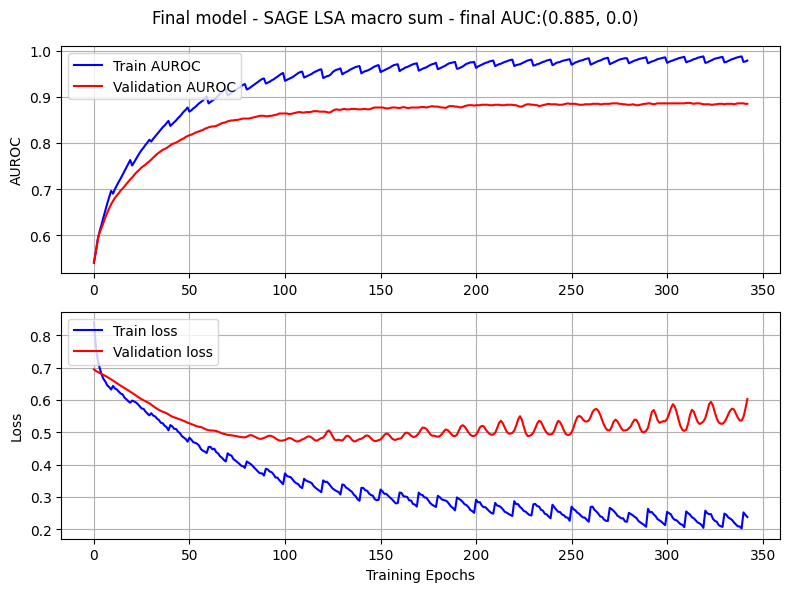

In [64]:
training_utils.plot_training_stats_sep(f"Final model - SAGE LSA macro sum - final AUC:{metrics}",*curves[0])

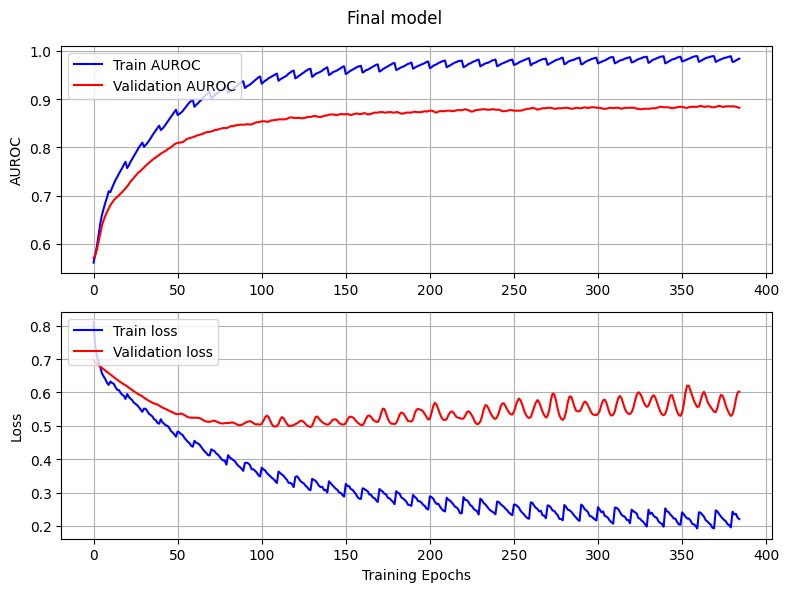

In [75]:
training_utils.plot_training_stats_sep("Final model",*curves[3])